In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm
%matplotlib inline
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
from matplotlib.colors import TwoSlopeNorm
import json
import geopandas as gpd
import requests
import plotly.express as px
from shapely import wkt
import os
import geojson
import csv
import warnings

from natsort import natsorted
from PIL import Image

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
pd.set_option('display.max_rows', 500)

In [4]:
res='results_covid/' 

## RKI data reading

In [5]:
# reading and drop the column LKNR
df1=pd.read_csv('data/7-days incidences1.csv').drop(['LKNR'], axis=1)

df2=pd.read_csv('data/7-days incidences2.csv').drop(['LKNR'], axis=1)
df1.head(2)

,LK,18.11.2020,19.11.2020,20.11.2020,21.11.2020,22.11.2020,23.11.2020,24.11.2020,25.11.2020,26.11.2020,...,2021/9/1,2021/9/2,2021/9/3,2021/9/4,2021/9/5,2021/9/6,2021/9/7,2021/9/8,2021/9/9,2021/9/10
0,LK Ahrweiler,143.8,156.1,159.1,156.1,172.2,139.1,139.9,136.8,119.9,...,122.7,148.8,188.0,177.0,199.3,183.4,197.2,208.7,171.8,191.8
1,LK Aichach-Friedberg,144.8,138.9,158.2,173.8,167.8,156.0,139.6,121.8,95.1,...,68.9,90.4,98.6,102.2,99.2,92.7,92.7,94.9,68.2,71.2


In [6]:
# merge two dataframes into one
df=df1.set_index('LK').join(df2.set_index('LK'))

In [7]:
#covert to date time, specify the format
df.columns = pd.to_datetime(df.columns,format='mixed',dayfirst=True).strftime("%Y-%m-%d")
# sort the columns by date
df = df.reindex(sorted(df.columns), axis=1)

In [8]:
# The average 7-days incidences over per week
df_covid=df.groupby(np.arange(len(df.columns)) // 7,axis=1).mean()
# rename and set the index as a column
df_covid = df_covid.reset_index().rename(columns={"index":"LK"})

In [9]:
'''
Solve the missing correct name of Berlin
'''
# compute the data from all regions in Berlin, sum it up
SK_Berlin=df_covid[df_covid.LK.str.contains('Berlin')].sum()
# rename the row
SK_Berlin=SK_Berlin.replace(SK_Berlin.LK,'SK Berlin')
# convert from series to dataframe
SK_Berlin=pd.DataFrame([SK_Berlin.tolist()], columns=SK_Berlin.index)

#remove the original Berlin data rows
df_covid = df_covid.drop(df_covid[df_covid.LK.str.contains('Berlin')].index)

# add the new combined row into original dataframe
df_covid=pd.concat([df_covid, SK_Berlin]).reset_index(drop=True)


In [10]:
'''
Resolve mismatches manually by observation

LK Vorpommern-Greifswald in df_covid --> duplicate to LK Vorpommern-Greifswald 1
LK Vorpommern-Rügenin in df_covid --> duplicate to LK Vorpommern-Rügenin 1
'''
VG=df_covid[df_covid.LK.str.contains('Vorpommern-Greifswald')]
VR=df_covid[df_covid.LK.str.contains('Vorpommern-Rügen')]
# rename the rows
VG=VG.replace('Vorpommern-Greifswald', 'Vorpommern-Greifswald 1',regex=True)
VR=VR.replace('Vorpommern-Rügen', 'Vorpommern-Rügen 1',regex=True)

#concat all dataframes
df_covid=pd.concat([df_covid,VG,VR]).reset_index(drop=True)

## Read geo data and combine it with covid data

In [11]:
"""
Read geo data of Germany

"geo_germay.pkl": contains geographic features of Germany that can be used to generate maps
"""
geo_ger=pd.read_pickle('data/geo_germany.pkl')
geo_ger.head(2)

,LK,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry
0,LK Karlsruhe,86.0,DEU,Germany,1.0,Baden-Württemberg,2.0,Karlsruhe,17.0,Karlsruhe,NaN,NaN,Landkreise,Rural district,"MULTIPOLYGON (((8.53890 48.95514, 8.53952 48.9..."
1,LK Konstanz,86.0,DEU,Germany,1.0,Baden-Württemberg,1.0,Freiburg,4.0,Konstanz,NaN,Constance,Landkreise,Rural district,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."


In [12]:
# get full columns for the covid data with geo germany
covid_columns=df_covid.columns.tolist()
geo_ger_columns=geo_ger.columns.tolist()
full_covid_columns=covid_columns+geo_ger_columns

# merge gis info to covid data
df_covid_gis=geo_ger.merge(df_covid, left_on='LK', right_on='LK')[full_covid_columns]
# remove the one of the same columns "LK"
df_covid_gis=df_covid_gis.loc[:,~df_covid_gis.columns.duplicated()].copy()

# Convert to Geo data
df_covid_gis = gpd.GeoDataFrame(
    df_covid_gis,crs="EPSG:4326", geometry=df_covid_gis.geometry)

df_covid_gis.head(2)

,LK,0,1,2,3,4,5,6,7,8,...,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry
0,LK Karlsruhe,108.542857,113.214286,128.428571,160.142857,203.914286,180.114286,127.600000,116.185714,122.828571,...,Baden-Württemberg,2.0,Karlsruhe,17.0,Karlsruhe,NaN,NaN,Landkreise,Rural district,"MULTIPOLYGON (((8.53890 48.95514, 8.53952 48.9..."
1,LK Konstanz,122.642857,96.357143,104.071429,117.114286,131.028571,114.371429,112.842857,112.800000,109.328571,...,Baden-Württemberg,1.0,Freiburg,4.0,Konstanz,NaN,Constance,Landkreise,Rural district,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."


## Maps generation

In [13]:
%%time
''' Get new df_covid_gis containing the updated data according to the following rules:

 - 4 weeks(points) in a row to start colouring from the second one
 - check the ratio of each two adjacents is greater than SHRESHOLD, keep all True value, inplace false with 0

'''
sub_gis_incidences=df_covid_gis.iloc[:,1:103]
sub_gis_incidences=sub_gis_incidences.reset_index(drop=True)

# check the ratio of each two adjacents is greater than SHRESHOLD
THRESHOLD = 1.2
# 4 points in a row start to colouring
for idx, row in sub_gis_incidences.iterrows():

    #initial the color each row(Landkreis)
    c_line=pd.Series([False]*sub_gis_incidences.shape[1])
    #incidences numebr for each landkreis along all weeks
    val=sub_gis_incidences.loc[idx,:]
    for i in range(1,len(row)-2):
        if (row[i]>THRESHOLD*row[i-1])&(row[i+1]>THRESHOLD*row[i])&(row[i+2]>THRESHOLD*row[i+1]):
#             c_line[i-1]=True
            c_line[i]=True
            c_line[i+1]=True
            c_line[i+2]=True
    #keep all value according true, inplace false with 0
#     print(len(c_line),len(val))
    val=val.where(c_line.values,0)
    sub_gis_incidences.loc[idx,:]=val

#assign values back to gis_incidences    
df_covid_gis.iloc[:,1:103]=sub_gis_incidences

CPU times: user 432 ms, sys: 3.7 ms, total: 436 ms
Wall time: 434 ms


CPU times: user 4.28 s, sys: 27.6 ms, total: 4.3 s
Wall time: 1.93 s


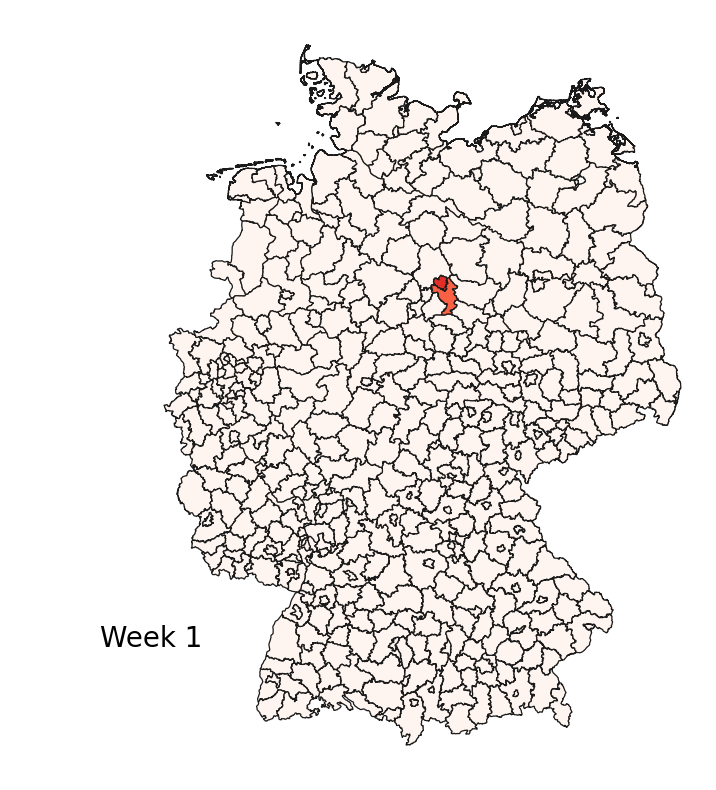

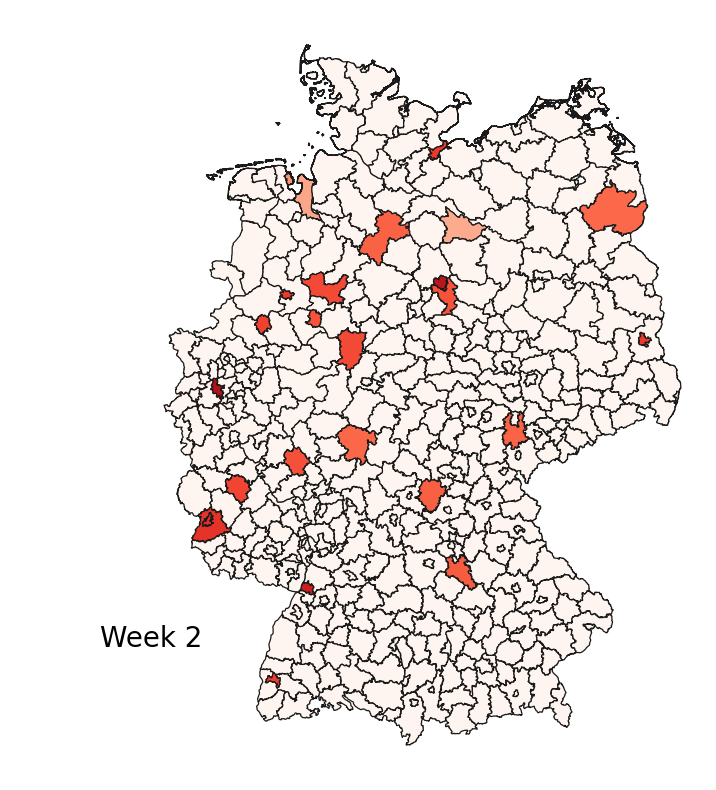

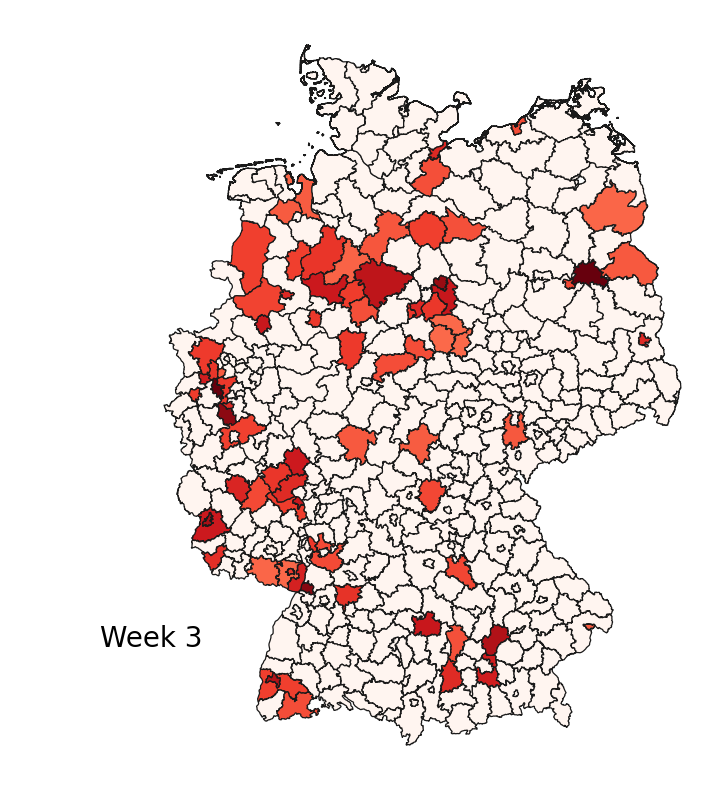

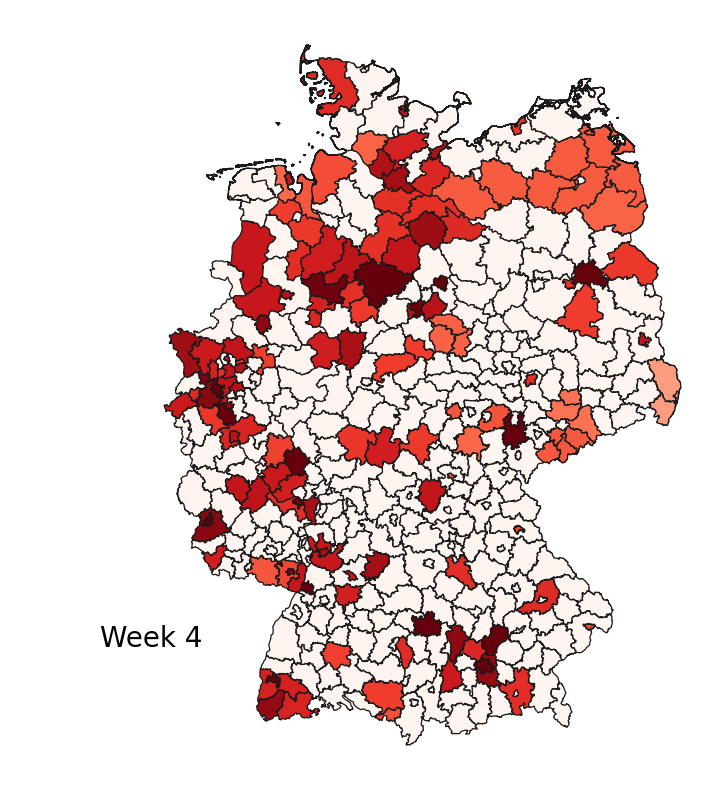

In [14]:
%%time
'''
Fick up 4 maps(weeks) as an example for the paper
If you want to know about other weeks, you can change the number of weeks
'''

# list of weeks (which are the column names at the moment)
list_of_weeks = df_covid_gis.iloc[:,1:103].columns.tolist()


# start the for loop to create one map per year
for week in list_of_weeks:
    if int(week)>30 and int(week)<35:
        norm1 = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=16) 
        # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
        fig = df_covid_gis.plot(column=week, cmap='Reds', figsize=(10,10), linewidth=0.9, rasterized=False, edgecolor='0.1',
    legend=False, norm=norm1)

        # remove axis of chart
        fig.axis('off')

        # Add prefix of column labels
        if int(week)==31:
            only_week ='Week 1'
        elif int(week)==32:
            only_week='Week 2'
        elif int(week)==33:
            only_week='Week 3'
        elif int(week)==34:
            only_week='Week 4'
        # position the annotation to the bottom left
        fig.annotate(only_week,
                xy=(0.1, .165), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize=20)

        # this will save the figure as pdf in the output path. you can also save as svg if you prefer.
        filepath = os.path.join(res, only_week+'.pdf')
        chart = fig.get_figure()
        chart.savefig(filepath, dpi=100, bbox_inches='tight')